# Neural network solver for "saprc99" (74 species) mechanism

This notebook is for my AM216 final project report, so it is more organized and self-contained than other notebooks in this folder (which contain my messy experiments). Besides standard Python modules, the only dependency is the KPP module generated by f2py. For the first time using this code, do:

```
$ cd ./strato_code
$ make kpp4py
```

Random seeds are explicitly specified for all stochastic parts (training data sampling, weight initializaion, SGD...), so all results should be reproducible.



# Preparation

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import seaborn as sns
from ipywidgets import interact, IntSlider

import torch

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

torch.__version__ # 0.4 has siginificant API change compared to 0.3

'0.4.0'

In [2]:
import saprc99_code.kpp4py as kpp # KPP Fortran integrator, compiled by f2py

# get variable names from source code
from read_results import read_varnames # simple ultility function
nvar = 74
varnames = read_varnames("saprc99_code/saprc99_Parameters.f90")[0:nvar]
print(varnames)

['H2SO4', 'HCOOH', 'CCO_OH', 'RCO_OH', 'CCO_OOH', 'RCO_OOH', 'XN', 'XC', 'SO2', 'O1D', 'ALK1', 'BACL', 'PAN', 'PAN2', 'PBZN', 'MA_PAN', 'H2O2', 'N2O5', 'HONO', 'ALK2', 'ALK3', 'TBU_O', 'ALK5', 'ARO2', 'HNO4', 'COOH', 'HOCOO', 'BZNO2_O', 'MEOH', 'ALK4', 'ARO1', 'DCB2', 'DCB3', 'CRES', 'DCB1', 'NPHE', 'ROOH', 'BALD', 'PHEN', 'CO', 'MGLY', 'ACET', 'HNO3', 'ETHENE', 'GLY', 'BZ_O', 'ISOPRENE', 'R2O2', 'TERP', 'METHACRO', 'OLE1', 'ISOPROD', 'OLE2', 'MVK', 'CCHO', 'HCHO', 'RNO3', 'O3P', 'RCHO', 'MEK', 'PROD2', 'O3', 'HO2', 'RO2_N', 'MA_RCO3', 'C_O2', 'BZCO_O2', 'RO2_R', 'NO', 'NO2', 'NO3', 'CCO_O2', 'RCO_O2', 'OH']


# Identify the range of input variables

## A single time series

In [3]:
df_init = pd.Series(data=1e-8, index=varnames)

with open ("saprc99_code/saprc99_Initialize.f90", "r") as f:
    code_str = f.readlines()

for i, line in enumerate(code_str):
    if 'VAR(2)' in line:
        startline = i
    if 'FIX(1)' in line:
        endline = i-1

CFACTOR = 2.447600e+13
for i in range(startline, endline):
    split = code_str[i].split()
    index = int(split[0][4:-1]) - 1 # Fortran -> Python
    valuestr = split[-1]
    # print(index, valuestr)
    df_init[index] = eval(valuestr)

df_init.head()

H2SO4      1.000000e-08
HCOOH      1.657025e+10
CCO_OH     2.839216e+10
RCO_OH     9.594592e+09
CCO_OOH    1.000000e-08
dtype: float64

In [4]:
# Integrate forward for multiple time steps
y_history = kpp.forward(df_init.values, 150)
y_history.shape

(75, 150)

In [5]:
df_history = pd.DataFrame(y_history.T, columns=varnames+['SUN'])
df_history.index.name = 'time'
df_history.head()

,H2SO4,HCOOH,CCO_OH,RCO_OH,CCO_OOH,RCO_OOH,XN,XC,SO2,O1D,...,C_O2,BZCO_O2,RO2_R,NO,NO2,NO3,CCO_O2,RCO_O2,OH,SUN
time,,,,,,,,,,,,,,,,,,,,,
0,2.131631e+10,1.941420e+10,2.994973e+10,1.275993e+10,8.695723e+05,4.160388e+05,5.950410e+07,4.906034e+12,1.202484e+12,0.072945,...,5.696964e+06,2.345523e+04,2.208117e+07,9.000156e+11,1.316153e+12,1.742790e+06,1.555662e+06,6.481562e+05,5.244521e+06,1.000000
1,4.417298e+10,2.437510e+10,3.207181e+10,1.710334e+10,9.292740e+06,4.451212e+06,2.741027e+09,4.931585e+12,1.179627e+12,0.216379,...,1.732457e+07,6.167814e+04,5.346038e+07,3.316187e+11,1.461165e+12,1.491187e+07,4.740948e+06,2.117670e+06,6.089295e+06,0.999220
2,7.278587e+10,2.982455e+10,3.286370e+10,1.871900e+10,7.719766e+07,3.730205e+07,2.363122e+10,5.010350e+12,1.151014e+12,0.391043,...,5.129260e+07,1.530285e+05,1.434036e+08,1.300213e+11,1.092018e+12,4.874537e+07,1.403130e+07,6.473448e+06,8.343999e+06,0.987575
3,1.097681e+11,3.544594e+10,3.363106e+10,1.944317e+10,7.498809e+08,3.586928e+08,7.330606e+10,5.171544e+12,1.114032e+12,0.550368,...,1.797156e+08,4.462390e+05,4.557147e+08,3.906664e+10,5.517341e+11,1.022524e+08,4.947643e+07,2.271533e+07,1.074183e+07,0.938153
4,1.434595e+11,4.025197e+10,3.919870e+10,2.214459e+10,6.370480e+09,2.971199e+09,1.141904e+11,5.302114e+12,1.080340e+12,0.574583,...,5.543973e+08,1.383080e+06,9.960480e+08,8.879201e+09,1.911030e+11,1.165292e+08,1.757165e+08,7.897251e+07,7.788335e+06,0.813302


/Users/zhuangjw/Research/Computing/miniconda3/envs/geo/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label
/Users/zhuangjw/Research/Computing/miniconda3/envs/geo/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


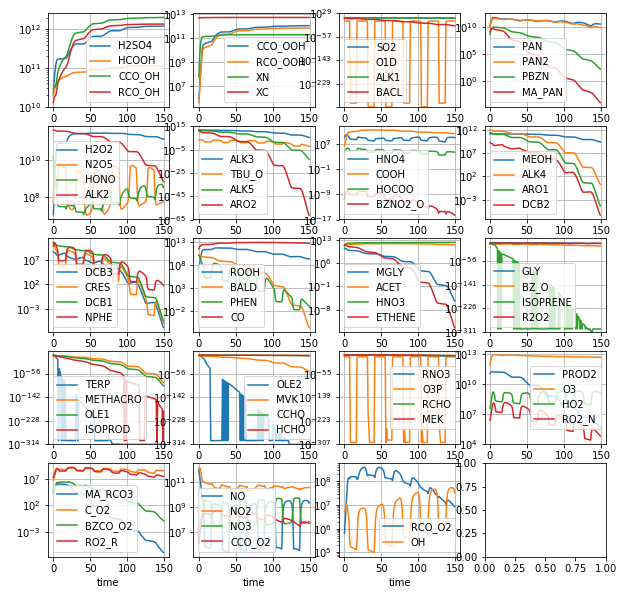

In [6]:
N_sub = 4
N_figures = 20

fig, axes = plt.subplots(N_figures//4, 4, figsize=[10, 10])

for i in range(N_figures-1):
    sub_name = varnames[i*N_sub:(i+1)*N_sub]
    df_history.plot(y=sub_name, logy=True, grid=True, ax=axes.ravel()[i])

In [7]:
df_range = df_history.agg(['min', 'max']).T
df_range.clip_lower(1e-8, inplace=True) # prevent small negative values
df_range.head()

,min,max
H2SO4,2.131631e+10,1.220569e+12
HCOOH,1.941420e+10,1.136111e+11
CCO_OH,2.994973e+10,2.037260e+12
RCO_OH,1.275993e+10,1.376256e+12
CCO_OOH,8.695723e+05,1.160900e+12


## Random sampling from the above range to get y0

In [8]:
N_train = 5000 # Number of training data. To use more training data, should train on GPU instead.

np.random.seed(42)
y0_list =  np.random.uniform(df_range['min'], df_range['max'],
                             size=(N_train, nvar+1))
y0_list.shape

(5000, 75)

## Integrate for one step (from y0 to y1) to get realistic correlation

In [9]:
%time y1_list = kpp.onestep(y0_list.T).T
y1_list.shape

CPU times: user 4.13 s, sys: 53.7 ms, total: 4.18 s
Wall time: 4.24 s


(5000, 74)

In [10]:
df_y1 = pd.DataFrame(y1_list, columns=varnames)
df_y1.head()

,H2SO4,HCOOH,CCO_OH,RCO_OH,CCO_OOH,RCO_OOH,XN,XC,SO2,O1D,...,MA_RCO3,C_O2,BZCO_O2,RO2_R,NO,NO2,NO3,CCO_O2,RCO_O2,OH
0,4.937056e+11,1.164822e+11,1.502672e+12,8.354409e+11,1.814492e+11,1.143670e+11,5.500953e+10,5.635373e+12,7.008988e+11,0.307854,...,115653.841066,1.087473e+08,1.116565e+05,1.667207e+08,7.188744e+10,9.506164e+11,8.139994e+07,2.977252e+07,6.605769e+06,1.010181e+07
1,8.966430e+11,9.995743e+10,1.833578e+11,5.096011e+11,1.355363e+11,6.330318e+11,1.612448e+11,5.246032e+12,7.839067e+10,0.126851,...,200329.460217,1.640665e+08,4.016099e+05,3.902192e+08,1.315730e+10,5.036233e+11,2.240616e+08,4.805304e+07,2.601526e+07,3.514818e+06
2,1.113113e+12,4.906869e+10,3.223967e+11,6.835724e+11,1.144337e+12,1.774033e+11,2.179172e+11,5.680885e+12,2.856617e+11,0.137609,...,163398.550181,5.384969e+07,4.116502e+04,1.068038e+08,3.522374e+10,1.489255e+12,3.324025e+08,1.485414e+07,5.041450e+06,2.532494e+06
3,3.160307e+11,1.159530e+11,8.223115e+11,1.235956e+12,7.328723e+11,5.828988e+11,1.719655e+11,5.515935e+12,5.917751e+11,0.031147,...,527898.649452,7.635691e+07,1.327572e+05,3.732986e+08,3.469246e+09,3.719307e+11,4.580194e+08,1.104738e+07,2.472973e+07,7.418328e+05
4,8.619731e+10,7.575917e+10,1.118727e+12,8.906125e+11,8.430989e+11,7.162606e+11,1.216575e+11,5.182678e+12,9.539587e+11,0.034695,...,756357.070112,1.016421e+08,1.023802e+06,5.656576e+08,1.252116e+09,2.179948e+11,7.545920e+08,1.083240e+07,6.721065e+07,6.235707e+05


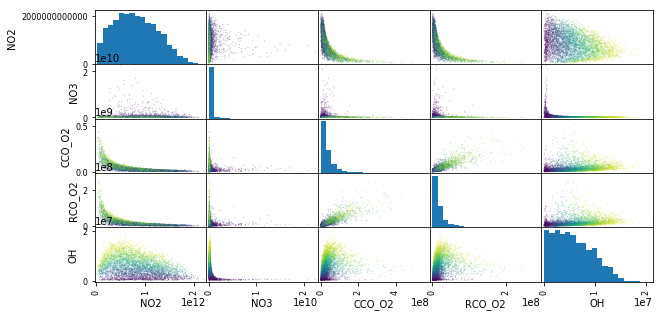

In [11]:
# just plot a subset of species
pd.plotting.scatter_matrix(df_y1.iloc[:,-5:], c=y0_list[:,-1], figsize=(10, 5), alpha=0.3, s=5, hist_kwds={'bins': 20});
# color is SUN intensity at the previous time step

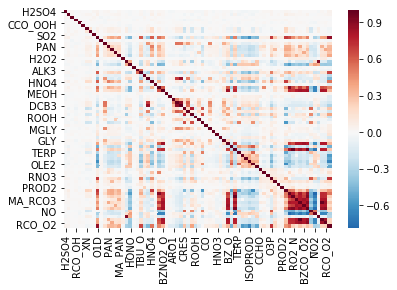

In [12]:
sns.heatmap(df_y1.corr(), cmap='RdBu_r', center=0.0)
# very strong correlation between species after reaction
# note that the correlation before integration (y0) is zero, due to random sampling

## See if the distribution of y1 is representative enough

In [13]:
# Integrate for one more step to see if there's any significant change in species distribution
np.random.seed(41)
SUN_new = np.random.rand(N_train, 1) # use new sun intensity
%time y2_list = kpp.onestep(np.c_[y1_list, SUN_new].T).T  
y2_list.shape

CPU times: user 2.52 s, sys: 34 ms, total: 2.55 s
Wall time: 2.57 s


(5000, 74)

In [14]:
# No significant change in species distribution
# Too many species, better explore interactively
@interact(n=IntSlider(min=0,max=nvar-1,step=1,value=0,continuous_update=True))
def plot_dist(n):
    plt.hist(y1_list[:,n], bins=20, alpha=0.5, label='before')
    plt.hist(y2_list[:,n], bins=20, alpha=0.5, label='after')
    plt.legend()
    plt.title(varnames[n])

interactive(children=(IntSlider(value=0, description='n', max=73), Output()), _dom_classes=('widget-interact',…

## Estimate the dimensionality of manifold

Use PCA as a quick and dirty estimate. Any better (non-linear) dimensionality estimate algorithm?

In [15]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

In [16]:
# Normalize data and apply PCA
# http://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html
Normed_PCA = lambda : make_pipeline(StandardScaler(), PCA(n_components=10))

In [17]:
def print_PCA(y_list):
    pca = Normed_PCA()
    pca.fit(y_list)
    ratio = pca.named_steps['pca'].explained_variance_ratio_
    print('Explained variance: \n', ratio)
    print('Accumulated: \n', np.cumsum(ratio))

In [18]:
print_PCA(y0_list) # evenly distributed due to uniform sampling

Explained variance: 
 [0.01580554 0.01560517 0.01554292 0.01524024 0.01507124 0.01501441
 0.01496444 0.01467923 0.01447167 0.01435626]
Accumulated: 
 [0.01580554 0.03141071 0.04695362 0.06219387 0.07726511 0.09227951
 0.10724396 0.12192319 0.13639486 0.15075112]


In [19]:
print_PCA(y1_list) # Dominated by the first 5 components

Explained variance: 
 [0.17670173 0.08019137 0.06758683 0.0571984  0.02554108 0.02238389
 0.02052848 0.0191403  0.01711812 0.01674855]
Accumulated: 
 [0.17670173 0.2568931  0.32447992 0.38167832 0.4072194  0.42960329
 0.45013177 0.46927206 0.48639018 0.50313873]


In [20]:
print_PCA(y2_list) # No Significant change compared to y2

Explained variance: 
 [0.18720495 0.08771404 0.06830535 0.06071416 0.03173243 0.02376355
 0.02306668 0.02150262 0.01926397 0.01772213]
Accumulated: 
 [0.18720495 0.27491899 0.34322435 0.40393851 0.43567094 0.45943449
 0.48250116 0.50400378 0.52326775 0.54098988]


# Preprocessing

Neural network requires input features to be normalized.

In [21]:
normalizer = StandardScaler()
normalizer.fit(y1_list[:,0:nvar]) # skip SUN, which is already in 0~1

StandardScaler(copy=True, with_mean=True, with_std=True)

In [22]:
X_train = np.c_[normalizer.transform(y1_list[:,0:nvar]), SUN_new]
X_train.shape

(5000, 75)

In [23]:
Y_train = normalizer.transform(y2_list) # use y1's scale
Y_train.std(axis=0) # highly normalized since y1 and y2 have similar distribution.

array([1.00131164, 1.00469624, 1.0001257 , 1.00001316, 1.00029106,
       1.00012086, 1.0063387 , 1.00335186, 0.98067792, 1.06470339,
       0.99449986, 0.97615514, 1.0179264 , 1.08431881, 1.05214432,
       1.08018818, 0.96805047, 0.88236849, 0.50482338, 0.97937496,
       0.95605348, 0.94344093, 0.8642568 , 0.72693268, 1.01985312,
       0.90325553, 1.07666578, 1.12385678, 0.98126128, 0.92746638,
       0.89955596, 0.8890261 , 0.78226882, 0.52078699, 0.88337266,
       0.74759792, 0.87798121, 0.82235538, 0.38913755, 0.99700493,
       0.89036365, 1.00208044, 1.02375045, 0.84524762, 0.88319016,
       1.08266336, 0.26690954, 1.26071155, 0.14683523, 0.67343243,
       0.58279805, 0.51024677, 0.19536235, 0.76119641, 0.82735836,
       0.80542508, 0.94839232, 0.82629282, 0.82532547, 0.97925939,
       0.9107051 , 0.96511258, 1.13609395, 1.24003125, 1.62050386,
       1.6501954 , 1.82812413, 1.29495271, 0.68938266, 0.91395848,
       1.10863703, 1.80225368, 1.98563885, 1.02926148])

# ANN training

In [24]:
# use torch.from_numpy() to share the same memory.
x_torch = torch.from_numpy(X_train)
y_torch = torch.from_numpy(Y_train)

In [25]:
# two-hidden-layer net performs significantly better than one-hidden-layer net
def two_layer_net(H=100):
    model = torch.nn.Sequential(
        torch.nn.Linear(nvar+1, H),
        torch.nn.Tanh(),
        torch.nn.Linear(H, H),
        torch.nn.Tanh(),
        torch.nn.Linear(H, nvar)
    )
    return model 

In [26]:
# weight initialization has no significant effect
# presumably because the net is quite small so it is easy to find minimum
torch.manual_seed(40) 
model = two_layer_net().double() # L-BFGS doesn't work at single precision. Not sure why.

In [27]:
%%time
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.LBFGS(model.parameters())
for t in range(200):
    
    def closure():
        optimizer.zero_grad()
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        loss.backward()
        return loss
    optimizer.step(closure)
    
    if (t+1)%20==0:
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        print(t+1, loss.item())

20 0.020640172789410143
40 0.014221162342182975
60 0.011589903619233706
80 0.010036128027283956
100 0.009065359936863403
120 0.00838181363992211
140 0.007820868902678876
160 0.007365330871516316
180 0.006989664823271432
200 0.0066728854798892385
CPU times: user 8min 44s, sys: 21.1 s, total: 9min 5s
Wall time: 3min 9s


In [28]:
%%time 
y_pred = model(x_torch)
y_pred_numpy = y_pred.detach().numpy() # 60x faster than KPP

CPU times: user 57.3 ms, sys: 4.41 ms, total: 61.7 ms
Wall time: 21.2 ms


In [29]:
r2_score(y_pred_numpy, Y_train, multioutput='raw_values')

array([0.99900502, 0.99896294, 0.99920938, 0.99920014, 0.9990778 ,
       0.99912755, 0.99792628, 0.9982444 , 0.99910378, 0.99762188,
       0.99907284, 0.9946571 , 0.99649659, 0.99589096, 0.99532949,
       0.99484691, 0.99842529, 0.95592013, 0.92159621, 0.99919434,
       0.99848871, 0.98994693, 0.99633775, 0.99206526, 0.98640879,
       0.99667348, 0.99119569, 0.98252683, 0.99907449, 0.99836678,
       0.99735292, 0.98591338, 0.98334196, 0.955292  , 0.99392213,
       0.97716865, 0.99565408, 0.99591659, 0.9046987 , 0.99886459,
       0.99628608, 0.9989518 , 0.99892036, 0.99620606, 0.9954948 ,
       0.98612055, 0.81445871, 0.99216117, 0.29284232, 0.99252411,
       0.98664353, 0.95535735, 0.74642865, 0.99327312, 0.9926346 ,
       0.99347398, 0.99632084, 0.99478339, 0.99472824, 0.9987674 ,
       0.99584013, 0.99796819, 0.99441487, 0.99145699, 0.99225755,
       0.99710735, 0.99376418, 0.99603282, 0.98330235, 0.99811126,
       0.98139272, 0.9959973 , 0.99551122, 0.99267682])

In [30]:
r2_score(y_pred_numpy, Y_train, multioutput='variance_weighted')

0.9932980231428891

## Scale-back to original concentration

In [31]:
y_pred_origin = normalizer.inverse_transform(y_pred_numpy)

In [32]:
def error_norm(y, y_true):
    """L1 error norm"""
    abserr = (np.abs(y - y_true)).mean(axis=0)
    return abserr/y_true.mean(axis=0)

In [33]:
error_norm(y_pred_origin, y2_list) # train error varies across species

array([1.28326726e-02, 8.75927174e-03, 1.17992236e-02, 1.17444669e-02,
       1.29419972e-02, 1.26528978e-02, 1.27547218e-02, 1.19265700e-03,
       1.26661032e-02, 2.60364798e-02, 8.76766391e-03, 2.53578480e-02,
       1.71970275e-02, 1.85146268e-02, 2.00962206e-02, 2.12829035e-02,
       1.57247436e-02, 2.81884884e-01, 1.44425460e-01, 1.22895610e-02,
       1.65698672e-02, 6.66181843e-02, 2.74783254e-02, 4.97545063e-02,
       4.14070286e-02, 2.41566753e-02, 4.67237652e-02, 1.01092745e-01,
       1.27181712e-02, 1.80196374e-02, 2.20629537e-02, 3.59654817e-02,
       4.60440957e-02, 1.55193904e-01, 2.34385729e-02, 1.07916219e-01,
       2.60204715e-02, 1.75324023e-02, 2.94364481e-01, 1.17508465e-02,
       1.67054708e-02, 7.85218561e-03, 9.83352954e-03, 2.75190495e-02,
       1.52693172e-02, 9.58235974e-02, 6.40118168e-01, 4.76549405e-02,
       2.41789939e+00, 5.39155530e-02, 7.59479840e-02, 1.55072266e-01,
       1.00110181e+00, 3.46606983e-02, 1.74012619e-02, 1.60061898e-02,
      

## Accuracy on test set

In [34]:
N_test = 10000

np.random.seed(39)
y0_test =  np.random.uniform(df_range['min'], df_range['max'],
                             size=(N_test, nvar+1))
%time y1_test = kpp.onestep(y0_test.T).T
y1_test.shape # this is the initial condition

CPU times: user 7.91 s, sys: 47 ms, total: 7.96 s
Wall time: 7.83 s


(10000, 74)

In [35]:
np.random.seed(38)
SUN_test = np.random.rand(N_test, 1) # use new sun intensity
%time y2_test = kpp.onestep(np.c_[y1_test, SUN_test].T).T
y2_test.shape

CPU times: user 4.84 s, sys: 30 ms, total: 4.87 s
Wall time: 4.87 s


(10000, 74)

In [36]:
X_test = np.c_[normalizer.transform(y1_test), SUN_test]
Y_test = normalizer.transform(y2_test) # true result for comparison
Y_test_pred = model(torch.from_numpy(X_test)).detach().numpy()

In [37]:
r2_test = r2_score(Y_test_pred, Y_test, multioutput='raw_values')
r2_test 

array([0.99881322, 0.99874377, 0.99890243, 0.99898101, 0.99880168,
       0.99890309, 0.99757549, 0.99798384, 0.99873879, 0.99734952,
       0.99882095, 0.99319519, 0.99557109, 0.9947756 , 0.99437568,
       0.99382653, 0.9982676 , 0.93442574, 0.91328572, 0.99892982,
       0.9982176 , 0.98689176, 0.99589674, 0.99046581, 0.98292612,
       0.99631539, 0.98835617, 0.96238843, 0.99868103, 0.99791589,
       0.99683347, 0.9850347 , 0.97987033, 0.94762962, 0.99321045,
       0.97273677, 0.99481526, 0.99554451, 0.88808888, 0.99859664,
       0.99575014, 0.99878678, 0.99874015, 0.99537521, 0.99483174,
       0.97470642, 0.72686278, 0.9880924 , 0.56999511, 0.99075018,
       0.98383575, 0.94428768, 0.74072631, 0.99234431, 0.99161773,
       0.99181205, 0.99581682, 0.99460746, 0.99378683, 0.998363  ,
       0.99478986, 0.99758467, 0.99322141, 0.98638418, 0.98435361,
       0.9951757 , 0.98998494, 0.99415626, 0.98238907, 0.99761088,
       0.95393947, 0.99360255, 0.9922133 , 0.99170688])

In [38]:
r2_test.min(), r2_test.argmin() # for worse case

(0.5699951116667082, 48)

In [64]:
varnames[48] # TERP has a weird, long-tail probability distribution, so has much larger error.

'TERP'

In [40]:
r2_score(Y_test_pred, Y_test, multioutput='variance_weighted')

0.9905641259845712

In [41]:
y2_test_pred = normalizer.inverse_transform(Y_test_pred)
y2_test_pred.shape

(10000, 74)

In [42]:
L1_test = error_norm(y2_test_pred, y2_test) # test error varies across species
L1_test

array([1.35959348e-02, 9.25708776e-03, 1.27834937e-02, 1.29009532e-02,
       1.34755613e-02, 1.37456797e-02, 1.32609690e-02, 1.25036604e-03,
       1.37888449e-02, 2.68287870e-02, 9.33791130e-03, 2.76675373e-02,
       1.80255437e-02, 2.00485602e-02, 2.15525938e-02, 2.28166460e-02,
       1.60925963e-02, 3.17278128e-01, 1.50521855e-01, 1.33925018e-02,
       1.72685769e-02, 7.22173660e-02, 2.82899518e-02, 5.27758111e-02,
       4.46676024e-02, 2.50639186e-02, 5.11348119e-02, 1.23589457e-01,
       1.35773932e-02, 1.91118379e-02, 2.38927673e-02, 3.78837299e-02,
       4.82082499e-02, 1.66375953e-01, 2.50111282e-02, 1.15530599e-01,
       2.80364083e-02, 1.83600215e-02, 3.15082679e-01, 1.26518557e-02,
       1.77609625e-02, 8.20175924e-03, 1.02804138e-02, 2.92327642e-02,
       1.63721320e-02, 1.13588515e-01, 7.08806598e-01, 5.38034075e-02,
       3.08670364e+00, 5.77898589e-02, 8.02523607e-02, 1.63842878e-01,
       1.18288700e+00, 3.60876137e-02, 1.82976586e-02, 1.72832638e-02,
      

In [43]:
L1_test.mean()

0.11530033582192599

In [44]:
L1_test.max(), L1_test.argmax()

(3.0867036356345103, 48)

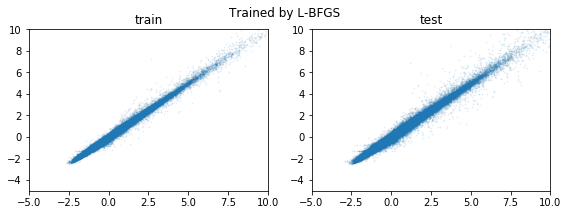

In [45]:
fig, axes = plt.subplots(1, 2, figsize=[8, 3])
axes[0].scatter(y_pred_numpy, Y_train, s=0.5, alpha=0.1)
axes[0].set_title('train')
axes[0].set_xlim(-5, 10); axes[0].set_ylim(-5, 10)

axes[1].scatter(Y_test_pred, Y_test, s=0.5, alpha=0.1)
axes[1].set_title('test')
axes[1].set_xlim(-5, 10); axes[1].set_ylim(-5, 10)

fig.suptitle('Trained by L-BFGS')
fig.tight_layout()

In [65]:
# Interactively plot the error for each species
@interact(i_var=IntSlider(min=0,max=nvar-1,step=1,value=48,continuous_update=True))
def plot_one_species(i_var):
    fig, axes = plt.subplots(1, 2, figsize=[8, 3])
    axes[0].scatter(y_pred_numpy[:,i_var], Y_train[:,i_var], alpha=0.5, s=1)
    axes[0].set_title('train')
    axes[1].scatter(Y_test_pred[:,i_var], Y_test[:,i_var], alpha=0.5, s=1)
    axes[1].set_title('test')
    fig.suptitle(varnames[i_var])

interactive(children=(IntSlider(value=48, description='i_var', max=73), Output()), _dom_classes=('widget-inter…

# Optimizer effect

## Mini-batch SGD

In [47]:
from torch.utils.data import DataLoader, TensorDataset # needed by SGD

In [48]:
torch.manual_seed(40) # use the same initial weight as L-BFGS case 
model_SGD = two_layer_net().double()

In [49]:
%%time
def training_SGD(model, batch_size=128, n_epoch=1200, i_print=150):
    """Use global x_torch and y_torch"""
    dataloader = DataLoader(dataset=TensorDataset(x_torch, y_torch), batch_size=batch_size, shuffle=True)
    
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())
    
    for epoch in range(n_epoch):
        
        for step, (batch_x, batch_y) in enumerate(dataloader): 
            optimizer.zero_grad()
            y_pred = model(batch_x)
            loss = loss_fn(y_pred, batch_y)
            loss.backward()
            optimizer.step()

        if (epoch+1)%i_print==0:
            print(epoch+1, loss.item()) # this is just the average loss on a mini-batch

torch.manual_seed(37) # deterministic shuffling
training_SGD(model_SGD)

150 0.01420289848414931
300 0.01909282076399289
450 0.008865255489514428
600 0.01066517856537737
750 0.011043587441747648
900 0.004317494565424085
1050 0.007963591067815527
1200 0.0035456506953261352
CPU times: user 6min 15s, sys: 4.2 s, total: 6min 20s
Wall time: 2min 12s


In [50]:
# training accuracy
Y_train_pred_SGD = model_SGD(x_torch).detach().numpy()
r2_score(Y_train_pred_SGD, Y_train, multioutput='raw_values')

array([0.99819311, 0.99823662, 0.99854477, 0.99836047, 0.99838675,
       0.99798467, 0.99673238, 0.9977613 , 0.99798239, 0.99728885,
       0.99835074, 0.99243908, 0.99564835, 0.99609398, 0.99470214,
       0.99446531, 0.99656607, 0.981362  , 0.98128192, 0.99818542,
       0.9974936 , 0.99007712, 0.99611538, 0.99373082, 0.99121921,
       0.99664496, 0.99117726, 0.98854494, 0.99839753, 0.99495066,
       0.99577392, 0.99023691, 0.98601725, 0.98093715, 0.99219144,
       0.98590735, 0.99631104, 0.99482076, 0.94265921, 0.99837963,
       0.99299787, 0.99780217, 0.99786378, 0.995982  , 0.99370236,
       0.99036979, 0.88227536, 0.99254779, 0.62849825, 0.98933143,
       0.98579861, 0.9701153 , 0.86742777, 0.99356669, 0.99142454,
       0.99265729, 0.99575167, 0.99586281, 0.99294086, 0.99717834,
       0.99583064, 0.99767443, 0.99652527, 0.99070792, 0.99399822,
       0.99739775, 0.99487283, 0.99618801, 0.98832618, 0.9969923 ,
       0.98708411, 0.99671087, 0.99661192, 0.99555336])

In [51]:
error_norm(normalizer.inverse_transform(Y_train_pred_SGD), y2_list) # ~2% error

array([1.78023108e-02, 1.16676157e-02, 1.66140070e-02, 1.72709180e-02,
       1.78466920e-02, 1.99976430e-02, 1.68644824e-02, 1.41047578e-03,
       2.00748443e-02, 2.85561571e-02, 1.22051951e-02, 3.16490397e-02,
       2.00530953e-02, 1.85555142e-02, 2.23303289e-02, 2.30474407e-02,
       2.42790981e-02, 2.01223269e-01, 8.65901327e-02, 1.92883076e-02,
       2.17105119e-02, 6.62448109e-02, 2.90957494e-02, 4.67595113e-02,
       3.28931902e-02, 2.53354962e-02, 4.69142153e-02, 9.13876341e-02,
       1.75336161e-02, 3.44567772e-02, 2.94718311e-02, 3.28949591e-02,
       4.38397024e-02, 1.01905470e-01, 2.81589542e-02, 8.92969267e-02,
       2.53084011e-02, 2.04705754e-02, 2.48439842e-01, 1.47176600e-02,
       2.30763918e-02, 1.20317269e-02, 1.45645119e-02, 2.93791008e-02,
       1.87939952e-02, 8.25801848e-02, 5.33044265e-01, 5.07007758e-02,
       2.43685788e+00, 6.96515472e-02, 8.26764083e-02, 1.26804545e-01,
       8.03701166e-01, 3.65642289e-02, 2.00848955e-02, 1.76489923e-02,
      

In [52]:
# test accuracy
Y_test_pred_SGD = model_SGD(torch.from_numpy(X_test)).detach().numpy()
r2_score(Y_test_pred_SGD, Y_test, multioutput='raw_values')

array([0.99725467, 0.99758731, 0.99782115, 0.99743484, 0.99767787,
       0.99714944, 0.99598858, 0.99671277, 0.99692604, 0.99673188,
       0.99736166, 0.99094704, 0.99451286, 0.99498231, 0.99276979,
       0.99300861, 0.99542145, 0.94280502, 0.97405729, 0.99749298,
       0.99685201, 0.98647521, 0.99524285, 0.99206921, 0.98841496,
       0.99583779, 0.98865455, 0.97179652, 0.99743413, 0.99397215,
       0.99497054, 0.98806552, 0.98025399, 0.97352421, 0.99080967,
       0.98194194, 0.99554829, 0.99359166, 0.90639957, 0.99749603,
       0.99129772, 0.99722226, 0.99714202, 0.99479485, 0.99220896,
       0.97913743, 0.75509792, 0.98861895, 0.61728936, 0.98707425,
       0.9824746 , 0.95583984, 0.77895481, 0.99187515, 0.98969518,
       0.99081296, 0.99467366, 0.99521807, 0.99149401, 0.99637112,
       0.99458113, 0.99704361, 0.99566463, 0.9865494 , 0.98659743,
       0.99605764, 0.99012295, 0.99421723, 0.98487116, 0.99587896,
       0.91671854, 0.99505097, 0.99331577, 0.99468594])

In [53]:
L1_test_SGD = error_norm(normalizer.inverse_transform(Y_test_pred_SGD), y2_test) 
L1_test_SGD 

array([2.08122960e-02, 1.29908295e-02, 1.88401389e-02, 2.05184688e-02,
       2.03279526e-02, 2.32359061e-02, 1.80003896e-02, 1.59986653e-03,
       2.32723678e-02, 3.02882771e-02, 1.38880458e-02, 3.42971162e-02,
       2.12622810e-02, 2.02453912e-02, 2.48840757e-02, 2.49805342e-02,
       2.70431929e-02, 2.51628336e-01, 9.42452754e-02, 2.12969202e-02,
       2.31417315e-02, 7.25217785e-02, 3.15962968e-02, 5.10103079e-02,
       3.62422722e-02, 2.73388072e-02, 5.14231330e-02, 1.09329300e-01,
       2.04150195e-02, 3.60692038e-02, 3.18376450e-02, 3.56969792e-02,
       4.70338425e-02, 1.12567416e-01, 3.01122452e-02, 9.60890514e-02,
       2.75367727e-02, 2.24209920e-02, 2.82518701e-01, 1.71149327e-02,
       2.54041531e-02, 1.28820004e-02, 1.60235048e-02, 3.14055693e-02,
       2.06497017e-02, 9.92185030e-02, 6.04705705e-01, 5.53534114e-02,
       3.13797623e+00, 7.42832185e-02, 8.77796984e-02, 1.40846663e-01,
       1.01159387e+00, 3.91803841e-02, 2.11158661e-02, 1.91498040e-02,
      

In [54]:
L1_test_SGD.mean()

0.11096727976692804

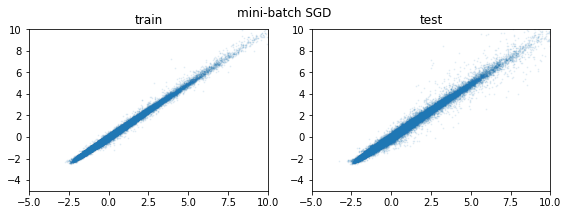

In [55]:
fig, axes = plt.subplots(1, 2, figsize=[8, 3])

axes[0].scatter(Y_train_pred_SGD, Y_train, s=0.5, alpha=0.1)
axes[0].set_title('train')
axes[0].set_xlim(-5, 10); axes[0].set_ylim(-5, 10)

axes[1].scatter(Y_test_pred_SGD, Y_test, s=0.5, alpha=0.1)
axes[1].set_title('test')
axes[1].set_xlim(-5, 10); axes[1].set_ylim(-5, 10)

fig.suptitle('mini-batch SGD')
fig.tight_layout()

# ANN prediction for multiple time steps

In [56]:
SUN_history = df_history['SUN']
SUN_history.shape

(150,)

In [57]:
X0 = np.c_[normalizer.transform(y1_test), np.ones(10000)*SUN_history[0]]

In [58]:
def predict_multistep(y_init, Nt, model=model):
    '''
    y_init : [n_sample, nvar]
    Use global variable SUN_history as the forcing term'''    
    N_sample = y_init.shape[0] # N_sample*Nt should not be too large
    Y_history = np.empty([Nt, N_sample, nvar])
    
    X = np.c_[normalizer.transform(y_init), np.ones(N_sample)*SUN_history[0]]
    for t in range(Nt-1):
        Y = model(torch.from_numpy(X)).detach().numpy()
        Y_history[t] = Y # record normalized result. Need to scale back later
        
        X = np.c_[Y, np.ones(N_sample)*SUN_history[t]]

    return Y_history

In [59]:
n_sample = 500
n_time = 10
%time y_pred_test_history = predict_multistep(y1_test[0:n_sample,:], n_time)
#normalizer.inverse_transform(y_pred_test_history, copy=False)
y_pred_test_history.shape

CPU times: user 34.4 ms, sys: 1.22 ms, total: 35.6 ms
Wall time: 18.6 ms


(10, 500, 74)

In [60]:
%%time
y_test_history = np.empty_like(y_pred_test_history)
for i in range(n_sample):
    y_test_history[:,i,:] = kpp.forward(y1_test[i,:], n_time).T[:, :-1]
normalizer.transform(y_test_history.reshape(-1, nvar), copy=False);

CPU times: user 2.25 s, sys: 7.24 ms, total: 2.26 s
Wall time: 2.09 s


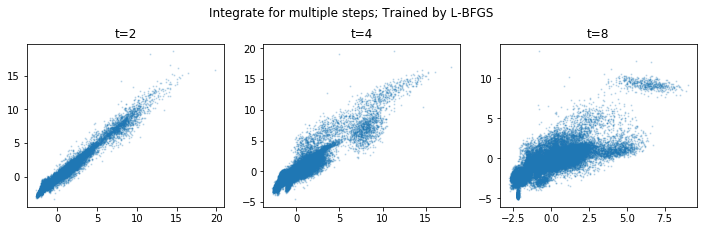

In [61]:
plt.figure(figsize=[12, 3])
for i, t in enumerate([2, 4, 8]):
    plt.subplot(1, 3, i+1)
    plt.scatter(y_test_history[t], y_pred_test_history[t], s=1, alpha=0.2)
    plt.title(f't={t}')
    
plt.suptitle('Integrate for multiple steps; Trained by L-BFGS', y=1.05)

## Use SGD-trained model to predict multi-steps

In [62]:
y_SGD_history = predict_multistep(y1_test[0:n_sample,:], n_time, model=model_SGD)

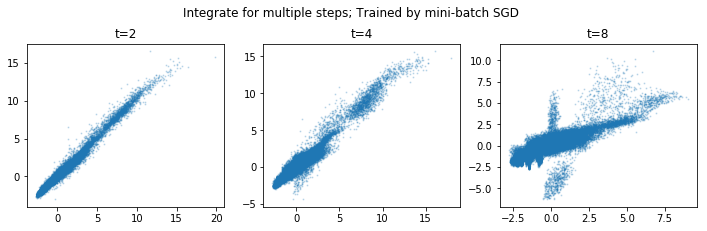

In [63]:
plt.figure(figsize=[12, 3])
for i, t in enumerate([2, 4, 8]):
    plt.subplot(1, 3, i+1)
    plt.scatter(y_test_history[t], y_SGD_history[t], s=1, alpha=0.2)
    plt.title(f't={t}')
    
plt.suptitle('Integrate for multiple steps; Trained by mini-batch SGD', y=1.05)